In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.modeling.models import CompoundNormSpectralModel, PowerLawNormPenSpectralModel

from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import  FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
sys.path.append('../')
import Dataset_load 
from Dataset_Creation import sys_dataset

## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov(simulated_dataset = True)

## Single Cases

In [4]:
norm = 0.1
tilt = 0.025


from gammapy.modeling.models.IRF import IRFModel, ERecoIRFModel, IRFModels, EffAreaIRFModel

effareamodel = EffAreaIRFModel()
erecomodel = ERecoIRFModel()
IRFmodels = IRFModels(eff_area_model= effareamodel,
                      e_reco_model = erecomodel,
                             datasets_names = dataset_asimov.name)


print(IRFmodels.parameters.names)


sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        bias = 0,
                        resolution = 0,
                        rnd = False,
                        e_reco_creation=10)
dataset_cor_N = sys_d_cor.create_dataset_N(10)
dataset_cor = sys_d_cor.create_dataset()




zero = 1e-12

    
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((6, 6))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/zero**2, 1/zero**2, 1/zero**2, 1/zero**2, 1/norm**2, 1/tilt**2])


dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix


# set bkg model:
import operator
compoundnorm  = CompoundNormSpectralModel(model1  = PowerLawNormSpectralModel(),
                                         model2 = PowerLawNormPenSpectralModel(),
                                         operator =  operator.mul)

bkg = FoVBackgroundModel(dataset_name=dataset_cor_N.name,
                        spectral_model = compoundnorm)
dataset_cor_N.models['dataset N-irf'].parameters.freeze_all()
models = Models(dataset_cor_N.models)
models.pop('dataset N-bkg')
models.append(bkg)
dataset_cor_N.models = models
dataset_cor_N.models['dataset N-bkg'].parameters['tilt_nuisance'].frozen = False
dataset_cor_N.models['dataset N-bkg'].parameters['tilt'].frozen = False

datasets_N  = [dataset_cor_N]
datasets  = [dataset_cor]


    
    
    
print(dataset_cor_N.models)
print(dataset_cor.models)    
    

['bias', 'resolution', 'norm_nuisance', 'tilt_nuisance', 'reference']
DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: IRFModels

  Name                      : dataset N-irf
  Datasets names            : dataset N
  EReco 

In [5]:
%%time
fitting = 0
if fitting :
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(datasets[0])
    print("saving")
    for i, d in enumerate(datasets):
        path = f'data/2_model_{norm}_tilt_{tilt}.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    path = f'data/2_model_{norm}_tilt_{tilt}.yml'
    datasets[0] = Dataset_load.load_dataset_N(datasets[0], path)        
        
        
   

read
CPU times: user 899 ms, sys: 2.67 s, total: 3.57 s
Wall time: 117 ms


In [6]:
%%time
fitting_N = 0
if fitting_N :
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run([datasets_N[0]])
    for i, d in enumerate(datasets_N):
        path = f'data/2_model_nui_{norm}_tilt_{tilt}.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    path = f'data/2_model_nui_{norm}_tilt_{tilt}.yml'
    datasets_N[0] = Dataset_load.load_dataset_N(datasets_N[0], path, bkg_sys = True)         
    

Parameter 'norm' not defined in YAML file. Using default value: 1.0 
Parameter 'tilt' not defined in YAML file. Using default value: 0.0 


read
CPU times: user 90.3 ms, sys: 28.8 ms, total: 119 ms
Wall time: 118 ms


In [8]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center#[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

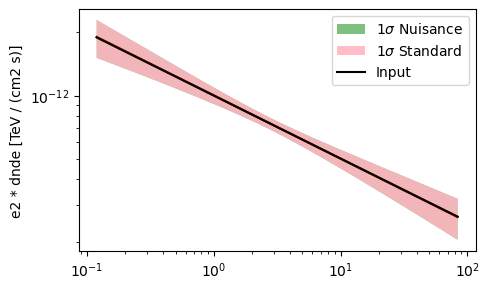

In [9]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (5,3))

datasets_N[0].models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    

datasets_N[0].models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
datasets[0].models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "red", alpha = 0.9)    

datasets[0].models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "lightpink",
                                                   alpha = 0.9)

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle='-', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()


## Compute Asimov Fluxpoints


In [ ]:
compute_fluxpoints = 1
if compute_fluxpoints:
    energy_edges = dataset_asimov.geoms['geom'].axes[0].edges
    esti  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = False)
    fluxpoints_asimov = esti.run([datasets[0]])
    fluxpoints_asimov.write("data/6_fluxpoints_asimov.fits", overwrite = True)
else:
    fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits", )
    


0.10000000000000002 TeV 0.1333521432163324 TeV
norm 1.0 0

0.1333521432163324 TeV 0.1778279410038923 TeV
norm 1.0 0

0.1778279410038923 TeV 0.23713737056616552 TeV
norm 1.0 0

0.23713737056616552 TeV 0.316227766016838 TeV
norm 1.0 0

0.316227766016838 TeV 0.4216965034285822 TeV
norm 1.0 0

0.4216965034285822 TeV 0.5623413251903491 TeV
norm 1.0 0

0.5623413251903491 TeV 0.7498942093324559 TeV
norm 1.0 0

0.7498942093324559 TeV 1.0 TeV
norm 1.0 0

1.0 TeV 1.333521432163324 TeV
norm 0.9982974927985468 0.08376941019804708

1.333521432163324 TeV 1.7782794100389232 TeV
norm 0.9975956000411023 0.09400917303849746

1.7782794100389232 TeV 2.371373705661655 TeV
norm 0.9981412831725534 0.10245963275311297

2.371373705661655 TeV 3.1622776601683795 TeV
norm 1.0000352293023012 0.11467586600373209

3.1622776601683795 TeV 4.216965034285822 TeV
norm 0.9996956776918198 0.1298912872538468

4.216965034285822 TeV 5.623413251903489 TeV
norm 1.0003898960517876 0.14944989898181985

5.623413251903489 TeV 7.49

In [ ]:
print(datasets_N[0].models)

In [ ]:
%%time
if compute_fluxpoints:

    esti_N  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = True)
    with datasets_N[0].models.restore_status():
        datasets_N[0].models.parameters.freeze_all()
        datasets_N[0].models[-1].parameters['norm_nuisance'].frozen = False
        #think abou t freezing the tilt nuisance here...
        datasets_N[0].models[-1].parameters['tilt_nuisance'].frozen = False
        fluxpoints_asimov_N = esti_N.run(datasets_N[0])

    fluxpoints_asimov_N.write("data/6_fluxpoints_asimov_N.fits", overwrite = True)
else:
    fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits",)
    

In [ ]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (5,3))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/6_fluxpoints_asimov."+ picformat)
